In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Input
import numpy as np

IMAGE_TO_DISPLAY = 3
CLASS_DICT = {"COAD":0,"LUSC":1,"SKCM":2 }
DATA_BATCH_SIZE = 32


In [ ]:
def create_generators() : 

  # create an ImageDataGenerator object with TIFF image format
  datagen = ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode="nearest",
    rescale=1./255, data_format='channels_last', dtype='float32')
  
    # read TIFF images from a directory
  train_datagenerator = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/FinalProject/project/data/train",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=DATA_BATCH_SIZE,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          subset='training',
                                          shuffle=True,
                                          interpolation='nearest')
  # read TIFF images from a directory
  val_datagenerator = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/FinalProject/project/data/validation",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=DATA_BATCH_SIZE,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          shuffle=False,
                                          interpolation='nearest')
  
  # read TIFF images from a directory
  test_datagenerator = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/FinalProject/project/data/test",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=DATA_BATCH_SIZE,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          shuffle=False,
                                          interpolation='nearest')
  
  print('Training', train_datagenerator)
  print('Validation', val_datagenerator)
  print('Test', test_datagenerator)

  return train_datagenerator, val_datagenerator, test_datagenerator

def display_images(datagenerator, image_number) :

  # create figure
  fig = plt.figure(figsize=(10, 7))
    
  # setting values to rows and column variables
  rows = 2
  columns = 2

  batch_size = 32
  for i in range(1,image_number):
      img, label = datagenerator.next()
      fig.add_subplot(rows, columns, i)
      print(img.shape)   #  (1,256,256,3)
      plt.title(label[0])
      plt.axis('off')
      plt.imshow(img[0])

In [12]:
def generate_age_and_class_values(generator, naming,column) :

  directory= '/content/gdrive/MyDrive/FinalProject/project/data_age/' 

  df1=pd.read_csv(directory+"/"+list(CLASS_DICT.keys())[0]+ "_" + naming +".csv")
  df2=pd.read_csv(directory+"/"+list(CLASS_DICT.keys())[1]+ "_" + naming +".csv")
  df3=pd.read_csv(directory+"/"+list(CLASS_DICT.keys())[2]+ "_" + naming +".csv")

  df1['age_normalized'] = (df1['age'] - df1['age'].min()) / (df1['age'].max() - df1['age'].min())
  df2['age_normalized'] = (df2['age'] - df2['age'].min()) / (df2['age'].max() - df2['age'].min())
  df3['age_normalized'] = (df3['age'] - df3['age'].min()) / (df3['age'].max() - df3['age'].min())

  min_age_value = 0
  max_age_value = 0
  
  table = []

  multi_classes = []
  iter = 0
  iter_prob = 0

  for file_name in generator.filenames:
    patient_id = file_name[10:22]
    
    iter = iter + 1
    #print(patient_id , file_name)
    try :
      df_result = df1.loc[df1["patient id"] == patient_id, column].item()
      min_age_value = df1['age'].min()
      max_age_value = df1['age'].max()
      table.append(df_result) 
      multi_classes.append(CLASS_DICT.get(list(CLASS_DICT.keys())[0]))
      continue    
    except :
      try : 
        df_result = df2.loc[df2["patient id"] == patient_id, column].item()
        min_age_value = df2['age'].min()
        max_age_value = df2['age'].max()
        table.append(df_result) 
        multi_classes.append(CLASS_DICT.get(list(CLASS_DICT.keys())[1]))
        continue 
      except:
        try :
          df_result = df3.loc[df3["patient id"] == patient_id, column].item()
          min_age_value = df3['age'].min()
          max_age_value = df3['age'].max()
          table.append(df_result)
          multi_classes.append(CLASS_DICT.get(list(CLASS_DICT.keys())[2]))
          continue 
        except:
          iter_prob = iter_prob + 1
          continue
      continue
  #return np.array(table, dtype=float), np.array(to_categorical(multi_classes, num_classes=3))
  return np.array(table, dtype=float), np.array(multi_classes, dtype=int), min_age_value, max_age_value


Found 689 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 148 images belonging to 3 classes.
Training <keras.preprocessing.image.DirectoryIterator object at 0x7f4c1e1a8760>
Validation <keras.preprocessing.image.DirectoryIterator object at 0x7f4c8a933250>
Test <keras.preprocessing.image.DirectoryIterator object at 0x7f4c1e1a8f70>
(32, 224, 224, 3)
(32, 224, 224, 3)


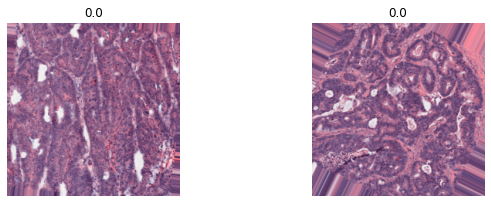

In [ ]:
train_generator, val_generator, test_generator = create_generators()

#obtain training and validation X
X_train=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])

X_val=np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])

X_test = np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])

display_images(train_generator, IMAGE_TO_DISPLAY)



In [13]:
 # create age layer
train_age_inputs, train_class_inputs,train_min_age, train_max_age = generate_age_and_class_values(train_generator, "train", "age_normalized")
val_age_inputs, val_class_inputs,val_min_age, val_max_age = generate_age_and_class_values(val_generator, "validation", "age_normalized")
test_age_inputs, test_class_inputs,test_min_age, test_max_age = generate_age_and_class_values(test_generator, "test", "age_normalized")

print(len(train_age_inputs),len(train_class_inputs))
print(len(val_age_inputs),len(val_class_inputs))
print(len(test_age_inputs),len(test_class_inputs))
print(train_min_age, train_max_age, val_min_age, val_max_age, test_min_age, test_max_age)


689 689
150 150
148 148
18 87 47 52 37 70


In [14]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in conv_model.layers:
    layer.trainable = False

# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(3, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

full_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=keras.optimizers.Adamax(lr=0.0001),
                  metrics=['acc'])

history = full_model.fit(X_train, train_class_inputs, validation_data = (X_val,val_class_inputs),batch_size=15,epochs=10)

58889256/58889256 [==============================] - 3s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


Epoch 1/10
46/46 [==============================] - 15s 124ms/step - loss: 1.1116 - acc: 0.3411 - val_loss: 1.1275 - val_acc: 0.3133
Epoch 2/10
46/46 [==============================] - 4s 88ms/step - loss: 1.0828 - acc: 0.3861 - val_loss: 1.1128 - val_acc: 0.3067
Epoch 3/10
46/46 [==============================] - 4s 88ms/step - loss: 1.0595 - acc: 0.4499 - val_loss: 1.1266 - val_acc: 0.3000
Epoch 4/10
46/46 [==============================] - 4s 89ms/step - loss: 1.0266 - acc: 0.5181 - val_loss: 1.1283 - val_acc: 0.3000
Epoch 5/10
46/46 [==============================] - 4s 89ms/step - loss: 0.9937 - acc: 0.5951 - val_loss: 1.1429 - val_acc: 0.2667
Epoch 6/10
46/46 [==============================] - 4s 89ms/step - loss: 0.9662 - acc: 0.5472 - val_loss: 1.1535 - val_acc: 0.3267
Epoch 7/10
46/46 [==============================] - 4s 89ms/step - loss: 0.9221 - acc: 0.6473 - val_loss: 1.1590 - val_acc: 0.3200
Epoch 8/10
46/46 [==============================] - 4s 89ms/step - loss: 0.8782 -

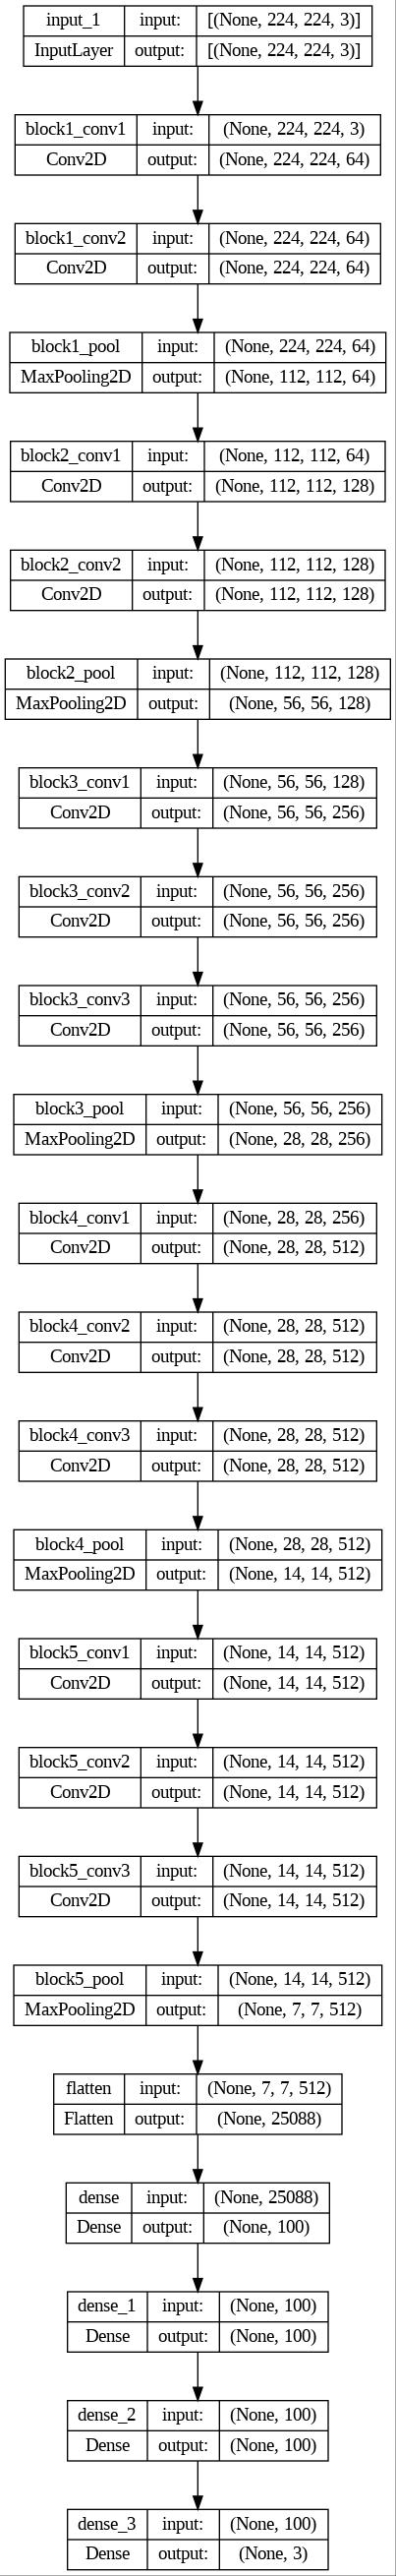

In [23]:
from keras.utils.vis_utils import plot_model
#Create the generators

plot_model(full_model,"VGG.jpg",show_shapes="True")

Callback Implementations

In [15]:
from keras.callbacks import ReduceLROnPlateau
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_classification_output_accuracy",
        min_delta=1,  # model should improve by at least 1%
        patience=100,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True)  # restore the best model with the lowest validation error)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,
                              verbose=0, mode='auto', min_delta=0.0001,
                              cooldown=0, min_lr = 1e-5)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(689, 224, 224, 3)
(148, 224, 224, 3)
(150, 224, 224, 3)


In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
print(np.min(X_train), np.max(X_train), np.mean(X_train), np.std(X_train))
print(np.min(X_test), np.max(X_test), np.mean(X_test), np.std(X_test))
print(np.min(X_val), np.max(X_val), np.mean(X_val), np.std(X_val))

print(0<np.min(X_val))

0.0 1.0 0.6621731 0.21365553
0.00016115108 1.0 0.6657402 0.20818731
0.0 1.0 0.6732705 0.19685283
False


In [ ]:
def get_data_from_cache(data_name) :
  directory="/content/gdrive/MyDrive/project/data/"
  pickle_in = open(directory+data_name,"rb")
  data = pickle.load(pickle_in)
  return data

In [ ]:
X_train = get_data_from_cache("X_train.pkl")
X_val = get_data_from_cache("X_val.pkl")
#y_train_age = get_data_from_cache("y_train_age.pkl")
#y_train_class = get_data_from_cache("y_train_class.pkl")
#y_val_age = get_data_from_cache("y_val_age.pkl")
#y_val_class = get_data_from_cache("y_val_class.pkl")

In [ ]:
#Train the mode
history = train_model(model, X_train, X_val,train_age_inputs,val_age_inputs,train_class_inputs, val_class_inputs, epochs_value=20, batch_size=32)

Model training is started!
Epoch 1/20
130/130 [==============================] - 438s 3s/step - loss: 6.8546 - classification_output_loss: 1.4748 - regression_output_loss: 1.5065 - classification_output_accuracy: 0.3380 - regression_output_mae: 0.9148 - val_loss: 4.2891 - val_classification_output_loss: 1.3754 - val_regression_output_loss: 0.2734 - val_classification_output_accuracy: 0.2559 - val_regression_output_mae: 0.4164 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 423s 3s/step - loss: 3.4875 - classification_output_loss: 1.2895 - regression_output_loss: 0.3172 - classification_output_accuracy: 0.3444 - regression_output_mae: 0.4436 - val_loss: 2.7104 - val_classification_output_loss: 1.2070 - val_regression_output_loss: 0.1317 - val_classification_output_accuracy: 0.4082 - val_regression_output_mae: 0.2885 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 426s 3s/step - loss: 2.3257 - classification_output_loss: 1.2384 - regression_output_lo

In [37]:
from random import sample
# Function that will pick a random set of images from the dataset
def get_random_images(num, X,y,y_pred,nseed=1):
    
    boundary = list(range(0, len(y)))
    
    values = sample(boundary, num)
    
    images = []
    labels = []
    classes = []
    preds = []
    
    for v in values:
      images.append(X[v])
      classes.append(y[v])
      if y[v] == 0 :
        labels.append("COAD")
      elif y[v] == 1 :
        labels.append("LUSC")
      else :
        labels.append("SKCM")
      preds.append(y_pred[v])

    return images, labels, classes, preds

In [42]:
def find_corresponding_label(y_value):
  
  if y_value == 0 :
    return "COAD"
  elif y_value == 1 :
    return "LUSC"
  else :
    return ("SKCM")
  

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


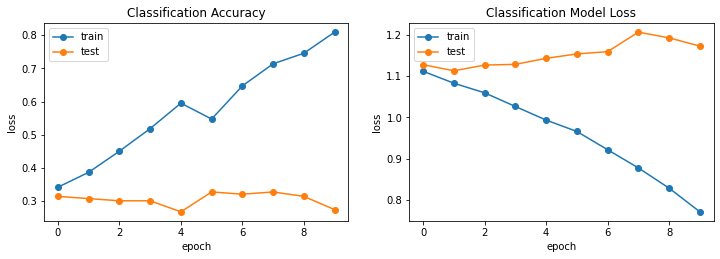

In [25]:
print(history)
print(history.history.keys())
# summarize history for accuracy

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['acc'],'-o')
plt.plot(history.history['val_acc'],'-o')
plt.title('Classification Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-o')
plt.title('Classification Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [27]:
Y_class_pred = full_model.predict(X_test, verbose=1)

Y_class_pred = Y_class_pred.argmax(axis=-1)




5/5 [==============================] - 1s 154ms/step


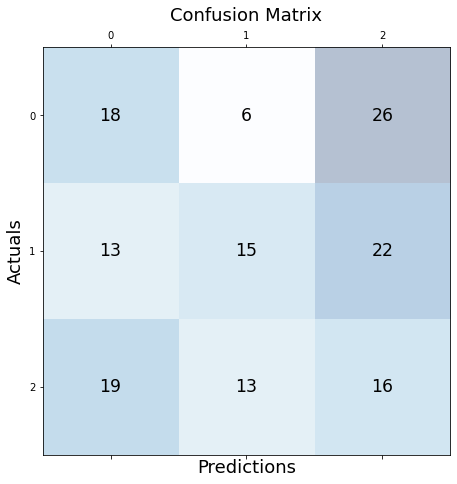

In [32]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=test_class_inputs, y_pred=Y_class_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Confusion Matrix

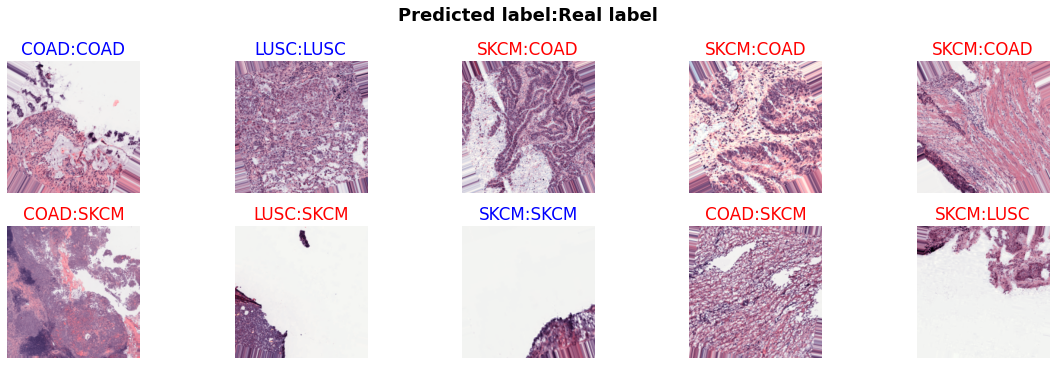

In [58]:
plt.rcParams.update({'font.size': 14})
images, labels, classes,preds = get_random_images(10, X_test,test_class_inputs,Y_class_pred)

fig = plt.figure(figsize=(16,15)) 
st = fig.suptitle("Predicted label:Real label", fontsize=18, 
                  fontweight="bold")

for ii in range(len(images)):
    image = images[ii]
    #image = to_np(images[ii])

    sub = fig.add_subplot(6, 5, ii+1)
    res = (classes[ii] == preds[ii])
    
    pred_label = find_corresponding_label(preds[ii])
    X_label = find_corresponding_label(classes)
    
    sub.set_title(pred_label + ":" + labels[ii] ,
                  fontdict = {"color": "blue" if res == True else "red"})
    
    plt.axis('off')
    plt.imshow(image)

fig.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.9)
plt.show()

In [59]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("F1 Score: ", f1_score(test_class_inputs, Y_class_pred, average="macro"))
print("Precision Score: ", precision_score(test_class_inputs, Y_class_pred, average="macro"))
print("Recall Score: ", recall_score(test_class_inputs, Y_class_pred, average="macro")) 


F1 Score:  0.3342857142857143
Precision Score:  0.3503921568627451
Recall Score:  0.3311111111111111


In [61]:
loss, accuracy = full_model.evaluate(x=X_test,
                                y=test_class_inputs,
                                batch_size=DATA_BATCH_SIZE)

print()
print(f'loss: {loss}')
print(f'classification_loss: {loss}')
print(f'classification_output_accuracy: {accuracy}')


5/5 [==============================] - 1s 136ms/step - loss: 1.1278 - acc: 0.3311

loss: 1.1277579069137573
classification_loss: 1.1277579069137573
classification_output_accuracy: 0.3310810923576355


Visualizing the Data

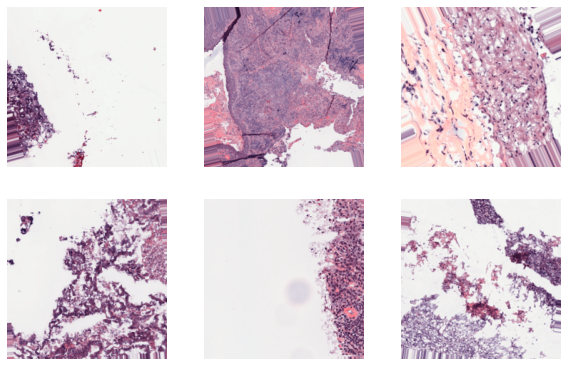

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(6):
    images, _ = next(train_generator)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0])
    plt.axis("off")
    

Augmentation Effects

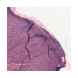

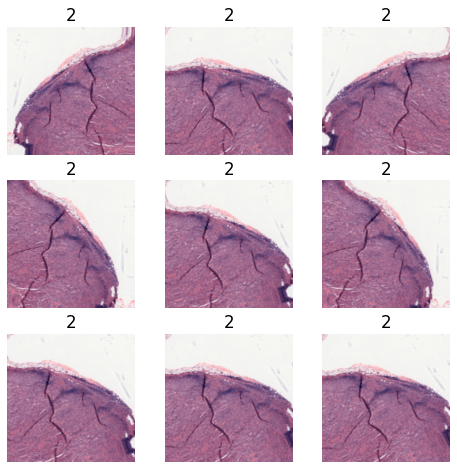

In [63]:
data_augmentation_horizontal = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)
import numpy as np

for i in range(1):
    images, labels = next(train_generator)
    ax = plt.subplot(3, 3, 1)
    plt.imshow(images[0])
    plt.axis("off")

    plt.figure(figsize=(8, 8))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation_horizontal(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy())
        plt.title(int(labels[0]))
        plt.axis("off")



In [64]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

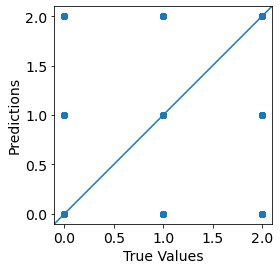

In [65]:
plot_diff(test_class_inputs, Y_class_pred)